In [ ]:
import numpy as np
import basix
import matplotlib.pyplot as plt
from basix import CellType, ElementFamily, LagrangeVariant, LatticeType
import jax_pn
from matplotlib.lines import Line2D
%load_ext autoreload
%autoreload 2

In [2]:

energy_groups = np.array([1.42907e+07, 1.00000e+06, 3.00000e+02, 1.00000e+01, 1.00000e-01])

plasma = (
    np.array([8.88507082, 0.0, 0.0, 0.0]),  # sigma_g
    np.zeros((6, 4, 4))  # sigma_l_gout_gin (all zeros)
)

tungsten_armor = (
    np.array([35.62796196, 55.19855355, 170.68293579, 97.62430527]),  # sigma_g
    np.array([
        [[ 3.30981502e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.23786233e+01,  5.39927385e+01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  3.81105370e-03,  1.44466525e+02,  1.33580218e-01],
         [ 0.00000000e+00,  0.00000000e+00,  6.34121092e-03,  4.26289394e+01]],
        [[ 1.74633605e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.42497322e-01,  7.97618562e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -8.29351683e-04,  4.65014502e-01,  3.91297892e-02],
         [ 0.00000000e+00,  0.00000000e+00, -1.87361531e-03,  1.75203903e+00]],
        [[ 1.43568377e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-5.63057553e-02,  3.44580388e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -3.07670565e-04, -7.27429723e-03,  1.95999255e-02],
         [ 0.00000000e+00,  0.00000000e+00, -5.14844961e-04,  3.37708238e-02]],
        [[ 1.19294691e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.00295216e-03,  1.13919178e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.43342420e-04, -4.30902562e-01,  4.93136604e-02],
         [ 0.00000000e+00,  0.00000000e+00,  1.46932234e-04,  7.67155835e-01]],
        [[ 9.75011766e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.51936726e-02,  3.19768662e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  2.58680837e-04, -3.37626089e-01,  8.51612036e-03],
         [ 0.00000000e+00,  0.00000000e+00,  5.40664309e-04,  1.22455518e-01]],
        [[ 8.12408076e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-3.15909978e-03,  1.81364732e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  4.02821611e-07,  4.95540772e-01, -3.56710582e-02],
         [ 0.00000000e+00,  0.00000000e+00, -5.33719860e-05,  1.27297386e-01]]
    ])
)

first_wall = (
    np.array([15.28360321, 22.77599714, 57.37177834, 59.02067236]),  # sigma_g
    np.array([
        [[ 1.35739102e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.47264631e+00,  2.27073391e+01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  3.71920704e-02,  5.67913293e+01,  1.58972770e-02],
         [ 0.00000000e+00,  0.00000000e+00,  2.24933173e-02,  5.73402116e+01]],
        [[ 5.86238206e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.42093512e-02,  2.09849877e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.19380091e-02,  6.39940915e-01,  9.59542653e-03],
         [ 0.00000000e+00,  0.00000000e+00, -7.19817190e-03,  6.81404367e-01]],
        [[ 4.70132164e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.32212713e-02,  1.68460566e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  9.36025916e-05,  6.19816549e-02,  2.18780421e-03],
         [ 0.00000000e+00,  0.00000000e+00, -6.53698616e-05, -1.33153790e-01]],
        [[ 3.40430933e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.30475963e-02,  1.62770030e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.23515743e-04,  1.18566666e-01, -2.29875869e-03],
         [ 0.00000000e+00,  0.00000000e+00,  6.21638288e-05,  3.16992612e-02]],
        [[ 2.48736323e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.42745972e-04,  1.42515822e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.35970420e-04,  7.19430772e-02, -3.98712470e-03],
         [ 0.00000000e+00,  0.00000000e+00, -1.34316710e-04, -1.73357264e-01]],
        [[ 1.67694811e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.33650490e-04,  3.39274089e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -5.25059140e-04, -7.96544962e-02, -3.85966729e-03],
         [ 0.00000000e+00,  0.00000000e+00,  3.03105854e-06, -6.13323799e-02]]
    ])
)

breeding_zone = (
    np.array([14.26520099, 33.2374296, 46.22254283, 64.78551751]),  # sigma_g
    np.array([
        [[ 1.27263811e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.68263604e+00,  3.22756614e+01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  2.62800524e-01,  3.99674013e+01,  2.72044739e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.01872030e-01,  4.01261596e+01]],
        [[ 5.69873316e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.63175461e-02,  2.63653402e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -7.65089532e-02,  2.32328167e+00,  2.60787954e-03],
         [ 0.00000000e+00,  0.00000000e+00, -3.47139625e-02,  2.34997165e+00]],
        [[ 3.56722532e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 1.21476924e-02,  4.79992444e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -5.16520833e-03,  4.91821817e-02,  2.39643838e-03],
         [ 0.00000000e+00,  0.00000000e+00,  2.52550546e-04,  4.81297066e-03]],
        [[ 2.00462038e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.95537183e-02,  4.83582428e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -8.44775908e-04,  4.30629484e-02,  2.11016838e-03],
         [ 0.00000000e+00,  0.00000000e+00,  4.91736887e-04,  8.59957616e-03]],
        [[ 1.07216613e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-3.41887931e-03,  2.48490116e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -4.63035411e-04,  1.62493885e-03,  1.77783070e-03],
         [ 0.00000000e+00,  0.00000000e+00, -4.66834907e-04, -9.65295073e-02]],
        [[ 4.94932801e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.56340688e-03,  1.77672427e-03,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  6.05788559e-05, -4.16034752e-03,  1.42673026e-03],
         [ 0.00000000e+00,  0.00000000e+00, -4.02825900e-06, -1.24300871e-01]]
    ])
)

back_supporting_structure = (
    np.array([14.77209636, 22.96845169, 54.47200191, 55.70180008]),  # sigma_g
    np.array([
        [[ 1.24942070e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.25795981e+00,  2.28111810e+01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  9.67748935e-02,  5.36368996e+01,  5.82725123e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.27187063e-01,  5.36495120e+01]],
        [[ 4.64231618e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-5.90813815e-02,  1.25643926e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -3.10286088e-02,  7.18068214e-01,  4.21791065e-03],
         [ 0.00000000e+00,  0.00000000e+00, -4.20798752e-02,  6.50962964e-01]],
        [[ 3.82012630e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.46871139e-02,  9.61673768e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -8.16188014e-04,  1.28078481e-02,  2.23290762e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.08101746e-03, -3.08412536e-02]],
        [[ 2.08341971e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.70518233e-02,  7.25544490e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.98970282e-04,  4.42525801e-02,  9.53335424e-04],
         [ 0.00000000e+00,  0.00000000e+00, -2.58888636e-05, -9.47098354e-03]],
        [[ 1.14886241e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.08587092e-03,  8.04990888e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.44134581e-04, -9.98122892e-03,  4.12105430e-04],
         [ 0.00000000e+00,  0.00000000e+00, -3.62110923e-04, -1.28478212e-03]],
        [[ 5.59608630e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.94979824e-03,  3.66068753e-03,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  3.15193776e-05,  1.61003934e-02,  1.07907715e-04],
         [ 0.00000000e+00,  0.00000000e+00, -3.32111930e-04, -1.38009632e-02]]
    ])
)

vv_wall_front = (
    np.array([24.44039741, 48.51043365, 88.89183676, 91.29762668]),  # sigma_g
    np.array([
        [[ 2.02577023e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 4.14585073e+00,  4.81968058e+01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.75784854e-01,  8.72837262e+01,  4.72404270e-03],
         [ 0.00000000e+00,  0.00000000e+00,  5.89969998e-01,  8.69088138e+01]],
        [[ 6.76159895e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.61604791e-01,  2.19505396e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -5.59894292e-02,  9.57622837e-01,  3.15556802e-03],
         [ 0.00000000e+00,  0.00000000e+00, -2.02398281e-01,  1.58826704e+00]],
        [[ 5.57742629e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 9.32512768e-02,  1.43047190e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.89497192e-03, -2.55776254e-02,  1.12146368e-03],
         [ 0.00000000e+00,  0.00000000e+00,  3.59768572e-03, -4.71665117e-01]],
        [[ 2.51342530e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-6.25062066e-02,  1.09156981e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  1.59441999e-03,  1.65931463e-01, -1.51215029e-04],
         [ 0.00000000e+00,  0.00000000e+00,  4.80587532e-03, -2.15759398e-01]],
        [[ 1.32974418e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.91303001e-02,  1.17182597e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -8.42861088e-04, -8.22885192e-03, -2.96211260e-04],
         [ 0.00000000e+00,  0.00000000e+00, -6.07784044e-03, -1.14983166e-01]],
        [[ 4.99412662e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 4.13827372e-03,  2.46399333e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.53108267e-03, -3.38389056e-02,  1.14031420e-04],
         [ 0.00000000e+00,  0.00000000e+00,  1.61791981e-03,  1.62309618e-02]]
    ])
)

vv_shield = (
    np.array([26.47837879, 82.79717601, 113.04865901, 116.92695037]),  # sigma_g
    np.array([
        [[ 1.75783052e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.75630464e+00,  7.68543671e+01,  0.00000000e+00,  0.00000000e+00],
         [ 8.45647746e-04,  5.53553434e+00,  9.66124369e+01,  1.62193366e-04],
         [ 4.10894125e-04,  1.83052937e-01,  1.55851386e+01,  1.01413898e+02]],
        [[ 7.36928750e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.66212746e+00,  2.54116983e+01,  0.00000000e+00,  0.00000000e+00],
         [ 9.70018107e-05,  2.14171330e+00,  3.00609316e+01,  1.18475218e-04],
         [ 9.56673483e-05,  1.72473635e-02,  6.58129813e+00,  3.19741496e+01]],
        [[ 5.66377710e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 7.93395421e-01,  1.13522342e+01,  0.00000000e+00,  0.00000000e+00],
         [-4.04915178e-04, -6.17607927e-01,  1.51388727e+01,  4.87926363e-05],
         [-1.72036114e-04, -8.69943812e-02, -1.67150354e+00,  1.47688177e+01]],
        [[ 3.01413788e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.10801549e+00,  1.41669720e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.41630228e-04, -1.42752214e+00,  3.99017864e+00, -1.93967678e-05],
         [-1.30536057e-04, -2.43641338e-02, -3.94754939e+00,  3.17768329e+00]],
        [[ 1.57585804e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-9.00345813e-01, -1.18628291e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.73264081e-04, -4.63214103e-01, -8.43293384e-01, -6.11782273e-05],
         [ 7.58404715e-05,  5.84478464e-02, -1.43987671e+00, -6.47577749e-01]],
        [[ 7.05655289e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-2.60766923e-01, -4.59181612e-01,  0.00000000e+00,  0.00000000e+00],
         [ 1.68556788e-04,  4.10931592e-01, -1.00158100e+00, -6.48254833e-05],
         [ 1.36212757e-04,  2.82734288e-02,  9.03335911e-01, -9.43603087e-01]]
    ])
)

vv_wall_back = (
    np.array([25.79247168, 51.11727444, 88.78516302, 92.20411034]),  # sigma_g
    np.array([
        [[ 2.19699856e+01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 3.62523764e+00,  5.06345155e+01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  2.88910130e-01,  8.68210498e+01,  3.11055824e-03],
         [ 0.00000000e+00,  0.00000000e+00,  1.07586836e+00,  8.63905171e+01]],
        [[ 8.17093304e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.45699763e-01,  2.49713044e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -1.00221140e-01,  1.37514701e+00,  1.84426019e-03],
         [ 0.00000000e+00,  0.00000000e+00, -3.78407230e-01,  7.50659477e-02]],
        [[ 6.64937463e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 6.48673482e-02,  1.66073168e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  6.80970615e-03,  8.67469213e-02,  8.50553181e-05],
         [ 0.00000000e+00,  0.00000000e+00,  8.76649594e-03, -1.42145790e-01]],
        [[ 3.66174097e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-4.63481600e-02,  1.86828389e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00, -4.45571897e-03,  1.11516247e-01, -1.14519665e-03],
         [ 0.00000000e+00,  0.00000000e+00,  2.43672929e-03,  1.85445612e-01]],
        [[ 2.08281486e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-5.02256373e-03,  1.23637773e-01,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  2.88338906e-03, -1.69530267e-02, -1.25185323e-03],
         [ 0.00000000e+00,  0.00000000e+00,  7.53813912e-04, -2.99178740e-01]],
        [[ 1.01427992e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-1.07524659e-02,  5.78436813e-02,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  2.13188124e-03,  1.57604197e-01, -4.19984418e-04],
         [ 0.00000000e+00,  0.00000000e+00,  1.20025912e-02,  4.25099841e-02]]
    ])
)

# Define zero sources for all materials
zero_source = np.array([0.0, 0.0, 0.0, 0.0])
one_source  = np.array([1.0, 0.0, 0.0, 0.0])
# Complete regions list with all 8 materials using actual HDF5 data
regions = [
    (0.2, *plasma, one_source),                    # Plasma
    (0.002, *tungsten_armor, zero_source),          # TungstenArmor  
    (0.025, *first_wall, zero_source),               # FirstWall
    (0.5, *breeding_zone, zero_source),             # BreedingZone
    (0.385, *back_supporting_structure, zero_source), # BackSupportingStructure
    (0.06, *vv_wall_front, zero_source),            # VVWallFront
    (0.2, *vv_shield, zero_source),                 # VVShield
    (0.06, *vv_wall_back, zero_source)              # VVWallBack
]


In [10]:
lagrange    = basix.create_element(ElementFamily.P, CellType.interval, degree= 5, lagrange_variant= LagrangeVariant.gll_warped)
L_max = 5
N_max = 3

pn = jax_pn.PN.PN_Problem.from_regions_per_region(regions = regions , elements_per_region= [5, 1, 1, 5, 3, 1, 3,1], N_max =  N_max, element = lagrange, L_scat=L_max)
pn.Solve_Multigroup_System("vacuum", 4)

ad_pn = jax_pn.ADPN.ADPN_Problem.from_regions_per_region(regions = regions , elements_per_region= [5, 1, 1, 5, 3, 1, 3,1], N_max =  N_max, element = lagrange, L_scat=L_max)
ad_pn.Solve_Multigroup_System("vacuum", 4)

dpn = jax_pn.DPN.DPN_Problem.from_regions_per_region(regions = regions , elements_per_region= [5, 1, 1, 5, 3, 1, 3,1], N_max =  N_max, element = lagrange, L_scat=N_max)
dpn.Solve_Multigroup_System("vacuum", 4)

Solving system with shape: (1616, 1616) and 1616 equations.
Solving system with shape: (1632, 1632) and 1632 equations.
Solving system with shape: (3232, 3232) and 3232 equations.
Solving system with shape: (3232, 3232) and 3232 equations.


array([ 1.08626951e-01,  1.06251013e-01,  1.02207901e-01, ...,
       -2.34738459e-10,  8.33812345e-10,  3.54491630e-12], shape=(3232,))

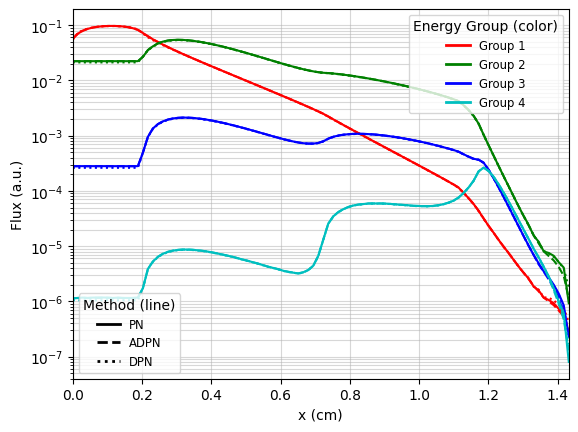

In [14]:
x_interp = np.linspace(0,2.232 - 0.8, 100)

pn_f = np.array([pn.interpolate_solution(x_interp, k=0, energy_group = eg ) for eg in range(4)]).T
ad_f = np.array([adpn.interpolate_solution(x_interp, k=0, energy_group = eg ) for eg in range(4)]).T
dp_f = np.array([0.5 * ( dpn.interpolate_solution(x_interp, k=0, energy_group = eg, mu_sign = -1) + dpn.interpolate_solution(x_interp, k=0, energy_group = eg, mu_sign = 1)) for eg in range(4)]).T

# Define colors and linestyles
colors = ['r', 'g', 'b', 'c']
labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
methods = ['PN', 'ADPN', 'DPN']
linestyles = ['-', '--', ':']

for i in range(4):
    plt.semilogy(x_interp, pn_f[:, i], color=colors[i], linestyle=linestyles[0])
    plt.semilogy(x_interp, ad_f[:, i], color=colors[i], linestyle=linestyles[1])
    plt.semilogy(x_interp, dp_f[:, i], color=colors[i], linestyle=linestyles[2])

# Build custom legend handles for clarity
from matplotlib.lines import Line2D

# Legend for energy groups (color)
color_handles = [Line2D([0], [0], color=colors[i], lw=2, label=labels[i]) for i in range(4)]
# Legend for methods (linestyle)
method_handles = [Line2D([0], [0], color='k', lw=2, linestyle=linestyles[j], label=methods[j]) for j in range(3)]

plt.xlim(0.0, 1.432)
plt.grid(which='both', alpha=0.5)
plt.xlabel('x (cm)')
plt.ylabel('Flux (a.u.)')
# Place both legends inside the plot
leg1 = plt.legend(handles=color_handles, title='Energy Group (color)', loc='upper right', fontsize='small')
plt.gca().add_artist(leg1)
plt.legend(handles=method_handles, title='Method (line)', loc='lower left', fontsize='small')